In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib
import numpy as np

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/


In [46]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)



[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [47]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.model.importance)

In [48]:
width = 0.03
ang = jnp.pi
num_position_grids = 51
num_angle_grids = 51
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

In [49]:
enumerators = b.make_enumerator(["contact_params_1"])

In [50]:
key = jax.random.PRNGKey(100)

In [51]:
def make_orientation_posterior_viz(observation, gt_contact, sampled_contacts):
    fig = plt.figure(constrained_layout=True)
    # fig.suptitle(f"Variance: {variance} Outlier Prob: {outlier_prob}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2],max=1.4)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Observation (params {gt_contact[0]:0.2f}, {gt_contact[1]:0.2f} ,{gt_contact[2]:0.2f})")
    # ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.set_aspect(1.0)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linestyle="--", linewidth=0.5)
    ax.add_patch(circ)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.scatter(-jnp.sin(sampled_contacts[:,2]),jnp.cos(sampled_contacts[:,2]), color='red',label="Posterior Samples", alpha=0.5, s=30)
    ax.scatter(-jnp.sin(gt_contact[2]),jnp.cos(gt_contact[2]), label="Actual", alpha=0.9, s=25)
    ax.set_title("Posterior on Orientation (top view)")
    # ax.legend(fontsize=9)
    # plt.show()
    return fig

In [52]:
def c2f_contact_update(trace_, key, contact_param_deltas):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_1"]
    scores = enumerators[3](trace_, key, contact_param_grid)
    i = scores.argmax()
    return enumerators[0](
        trace_, key,
        contact_param_grid[i]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update)

In [53]:
key = jax.random.PRNGKey(100)
key2 = jax.random.PRNGKey(1000)

In [54]:
grid_params = [
    (0.3, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)), (0.02, jnp.pi, (9,9,51)), (0.01, jnp.pi/5, (15,15,15)), (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [67]:
key = jax.random.split(key,2)[0]

[ 0.03026958 -0.16631588 -3.0059934 ]


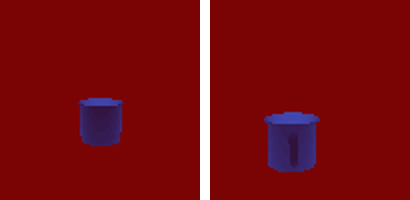

In [68]:
low, high = jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(21),
    "id_1": jnp.int32(13),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 3,
    "face_child_1": 2,
    "variance": 0.0001,
    "outlier_prob": 0.0001,
    "contact_params_1": jax.random.uniform(key, shape=(3,),minval=low, maxval=high)
}), (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.5, -0.5, -2*jnp.pi]), jnp.array([0.5, 0.5, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
)
gt_poses = b.get_poses(trace)
gt_contact = trace["contact_params_1"]
print(gt_contact)
trace = b.update_address(trace, key, "contact_params_1", jnp.zeros(3))
b.viz_trace_rendered_observed(trace)

[ 0.03000005 -0.16571426  3.2911932 ]
CPU times: user 11.3 s, sys: 10.4 ms, total: 11.3 s
Wall time: 8.86 s


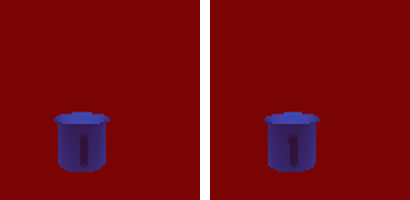

In [69]:
%%time
path = []
path.append(trace)
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
    path.append(trace)
print(trace["contact_params_1"])
b.viz_trace_rendered_observed(trace)

In [70]:
%%time
contact_param_grid = trace["contact_params_1"] + contact_param_deltas
weights =  jnp.concatenate([
    enumerators[3](trace, key, cp)
    for cp in jnp.array_split(contact_param_grid, 15)
],axis=0)

CPU times: user 5.18 s, sys: 4.87 ms, total: 5.18 s
Wall time: 4.27 s


In [71]:
key2 = jax.random.split(key, 1)[0]
normalized_weights = b.utils.normalize_log_scores(weights)
sampled_indices = jax.random.choice(key2,jnp.arange(normalized_weights.shape[0]), shape=(2000,), p=normalized_weights)
sampled_contact_params = contact_param_grid[sampled_indices]


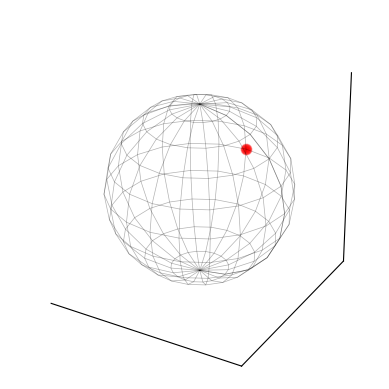

In [87]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
u, v = np.mgrid[0:2*np.pi:21j, 0:np.pi:11j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.axes.set_xlim3d(-1.1, 1.1) 
ax.axes.set_ylim3d(-1.1, 1.1) 
ax.axes.set_zlim3d(-1.1, 1.1) 
ax.set_aspect("equal")
ax.plot_wireframe(x, y, z, color=(0.0, 0.0, 0.0, 0.3), linewidths=0.5)


ax.axes.set_zticks([])
ax.axes.set_xticks([])
ax.axes.set_yticks([])

# points = []
# NUM = 1
# offset = jnp.pi/2
# scaling = 0.96
# for i in sampled_contact_params:
#     points.append(np.array([np.cos(i[2] + offset) * scaling, np.sin(i[2] + offset) * scaling,0.0]))
# points = np.array(points)

z = 0.1
# for i in np.arange(.1,1.01,.1):
#     ax.scatter(points[:,0], points[:,1],points[:,2], s=(40*i*(z*.9+.1))**2, color=(1,0,0,.3/i/10))
angle = jnp.pi/4 - jnp.pi/4
for i in np.arange(.1,1.01,.1):
    ax.scatter(np.cos(angle + offset) * scaling, np.sin(angle + offset), 0.0, s=(40*i*(z*.9+.1))**2, color=(1,0,0,.3))

# plt.tight_layout()
plt.savefig("sphere.pdf")

In [73]:
scaled_up_intrinsics = b.scale_camera_parameters(intrinsics, 4)

b.setup_renderer(scaled_up_intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (416, 416, 1024)


In [74]:
img = b.RENDERER.render(gt_poses, b.get_indices(trace))

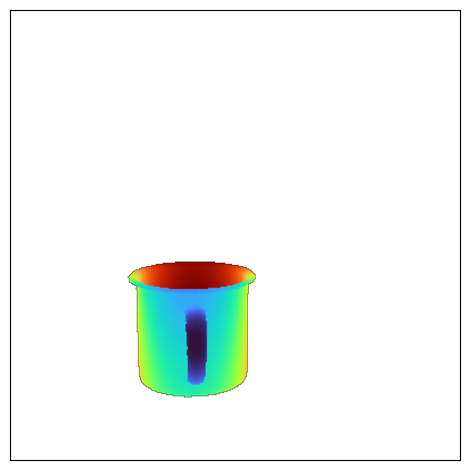

In [75]:
depth = img[...,2]
minval = jnp.min(depth[depth > jnp.min(depth)])
maxval = jnp.max(depth[depth < jnp.max(depth)])
depth = depth.at[depth >= intrinsics.far].set(jnp.nan)
viz_img = np.array(b.viz.scale_image(b.get_depth_image(
   depth, min=minval,  max=maxval
), 3))
viz_img[viz_img.sum(-1) == 0,:] = 255.0
plt.imshow(viz_img)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("mug.pdf")

In [76]:
sampled_contact_params

Array([[ 0.03000005, -0.16571426,  3.2911932 ],
       [ 0.03000005, -0.16571426,  3.2911932 ],
       [ 0.03000005, -0.16571426,  3.2911932 ],
       ...,
       [ 0.03000005, -0.16571426,  3.2911932 ],
       [ 0.03000005, -0.16571426,  3.2911932 ],
       [ 0.03000005, -0.16571426,  3.2911932 ]], dtype=float32)

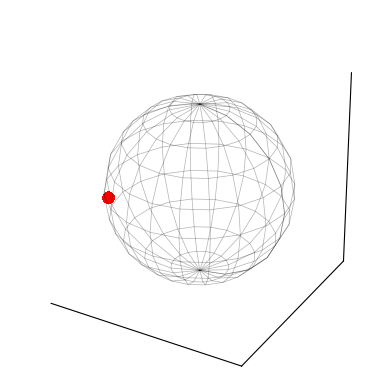

In [72]:
points

array([[-0.7589463 , -0.65115321,  0.        ],
       [-0.7589463 , -0.65115321,  0.        ],
       [-0.7589463 , -0.65115321,  0.        ],
       ...,
       [-0.7589463 , -0.65115321,  0.        ],
       [-0.7589463 , -0.65115321,  0.        ],
       [-0.7589463 , -0.65115321,  0.        ]])

In [50]:
jnp.linalg.norm(points,axis=-1)

Array([0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999

In [48]:
points

array([[ 0.        , -0.65115309,  0.75894636],
       [ 0.        , -0.65115309,  0.75894636],
       [ 0.        , -0.65115309,  0.75894636],
       ...,
       [ 0.        , -0.65115309,  0.75894636],
       [ 0.        , -0.65115309,  0.75894636],
       [ 0.        , -0.65115309,  0.75894636]])

(-0.17123723030090332, -0.0712372362613678)

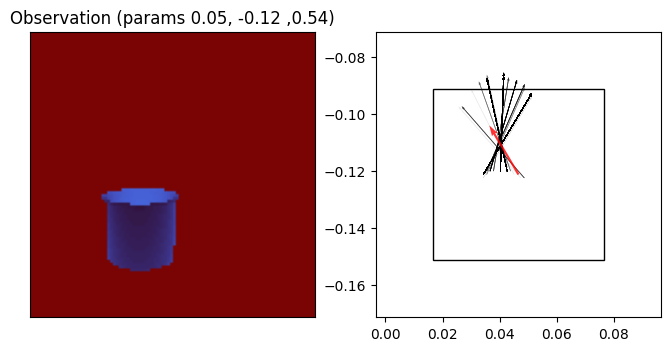

In [30]:

fig = plt.figure(constrained_layout=True)

observation =  trace["image"]

# fig.suptitle(f"Variance: {variance} Outlier Prob: {outlier_prob}")
widths = [1, 1]
heights = [2]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax = fig.add_subplot(spec[0, 0])
ax.imshow(jnp.array(b.get_depth_image(observation[...,2],max=1.4)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f"Observation (params {gt_contact[0]:0.2f}, {gt_contact[1]:0.2f} ,{gt_contact[2]:0.2f})")
# ax.set_title(f"Observed Depth")


dist = 0.6
ax = fig.add_subplot(spec[0, 1])
ax.quiver(
    sampled_contact_params[:,0],sampled_contact_params[:,1],
    -jnp.sin(sampled_contact_params[:,2]),jnp.cos(sampled_contact_params[:,2]),
    scale=3.0,
    alpha=0.1
         )

ax.quiver(
    gt_contact[0],gt_contact[1],
    -jnp.sin(gt_contact[2]), jnp.cos(gt_contact[2]),
    scale=5.0,
    alpha=0.8,
    color="red"
)

ax.set_aspect(1.0)
from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((gt_contact[0]-width, gt_contact[1]-width), 2*width, 2*width,fill=None))

ax.set_xlim(gt_contact[0]-width-0.02, gt_contact[0]+width+0.02)
ax.set_ylim(gt_contact[1]-width-0.02, gt_contact[1]+width+0.02)

In [ ]:
best_cell_idx = jnp.abs(contact_param_grid - gt_contact).sum(1).argmin()
print(gt_contact, contact_param_grid[best_cell_idx])
normalize_log_weights = w1eights - b.logsumexp(weights)
assert(weights.shape[0] == contact_param_grid.shape[0])
volume = (width / num_position_grids)**2 * (2*jnp.pi / num_angle_grids)
log_likelihood = normalize_log_weights[best_cell_idx] - jnp.log(volume)
print(log_likelihood)